# Twitter Covid Vaccination Data classifier with pre-trained BERT

In this assignment, our task was to develop a sentiment classifier with 3 classes (pro-vax, anti-vax, neutral) on the Covid Vaccination tweets dataset by fine-tuning the
pretrained BERT-base-uncased model available on [Hugging Face](https://huggingface.co/models).

## First Steps

**GPU Info**

To get the same results (best ones) you should have a Tesla T4 GPU. Because google colab does not give you the same GPU every time, you must keep closing and re-opening sessions until you get a Tesla T4 GPU like the one below.

In [ ]:
!nvidia-smi

Sat Mar  5 23:33:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Mount Google Drive(to read the datasets)**

We will first mount the google drive storage to load the datasets. It is not necessary, but I did it this way in order to avoid uploading them every time. If you want, you can upload yours and just change the import paths. 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Install pytorch interface for pre-trained BERT**

Then, we will install the interface to use the pre-trained BERT model.

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 5.5 MB/s 
     |████████████████████████████████| 67 kB 3.9 MB/s 
     |████████████████████████████████| 6.5 MB 38.8 MB/s 
     |████████████████████████████████| 596 kB 38.9 MB/s 
     |████████████████████████████████| 895 kB 44.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


**Import necessary libraries**

Now, it's time to import the necessary libraries for this notebook.

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re
import random
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

pd.set_option('max_colwidth', 500)
%matplotlib inline

**Enable CUDA**

Enable CUDA for GPU utilization by our model. This makes calculations and thus the training of our models faster.

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

**Set random seed**

Set a constant random seed in order to get the same (deterministic) outputs every time we run our models.


In [ ]:
seed = 17064
def reset_seed():
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
reset_seed()

**BERT model definition**

And here, we define the name of the pre-trained bert model from [Hugging Face](https://huggingface.co/models) which we'll use.

In [ ]:
BERT_MODEL_NAME = 'bert-base-uncased'

## Dataset loading

Now, let's load our datasets:

**Train Dataset**

In [ ]:
train_dataset = pd.read_csv('gdrive/MyDrive/NLP exercises/Datasets/Twitter Covid Vaccination data/vs_train.csv')
train_dataset.drop(['Unnamed: 0'], axis=1, inplace=True)
train_dataset

,tweet,label
0,Sip N Shop Come thru right now #Marjais #PopularNobodies #MMR 🙌🙌🙌🙌 @ Marjais SipNShop http://t.co/JfWAH7uzWE,0
1,I don't know about you but My family and I will not take the #Covid19 vaccine anytime soon...,1
2,"@MSignorile Immunizations should be mandatory. Period. In Oklahoma, they won't let kids go to school without them. It's dangerous otherwise!",2
3,"President Obama spoke in favor of vaccination for children. Fox will start telling its viewers to ""choose"" against vaccination in 3,2,1...",0
4,"""@myfoxla: Arizona monitoring hundreds for measles linked to Disneyland http://t.co/tEoU2zAQat"" It's a Small World After All.",0
...,...,...
15971,@Salon if u believe the anti-vax nutcases caused measles u are ignoring the Obama illegal children who streamed to the US. coincidence?,1
15972,How do you feel about parents who don't #vaccinate their kids?\r\nhttps://t.co/k3O7Al8Au3\r\n#MeaslesOutbreak,0
15973,70 Preschoolers Tested for Measles in Simi Valley http://t.co/pTRjYu8SVr,0
15974,"Finance Minister: Budget offers room to procure COVID-19 vaccines, if available https://t.co/VLdKXat3NJ",0


**Validation Dataset**

In [ ]:
validation_dataset = pd.read_csv('gdrive/MyDrive/NLP exercises/Datasets/Twitter Covid Vaccination data/vs_dev.csv')
validation_dataset.drop(['Unnamed: 0'], axis=1, inplace=True)
validation_dataset

,tweet,label
0,"@user They had a massive surge in with covid deaths immediately after the vaccine rollout, way more than they had during the entirety of the ""pandemic"" up to that point. Fuck those jabs, Dr.Death.",1
1,Required vaccines for school: Parents and guardians of children with school exclusion letters now have an... http://t.co/KVl8Dt86dz,0
2,“@KCStar: Two more Johnson County children have measles http://t.co/Rvx07sc” @sethmnookin,0
3,"NV can do better. Which states are the best (and worst) at vaccinating their kids http://t.co/6GaZGgYA9z http://t.co/pTFRJZ2Tmr""",2
4,Nothing like killing ourselves w/ our own fear MT@Alyssa_Milano: Vaccine fears have fueled the resurgence of preventable diseases.,2
...,...,...
2277,"RT @abc7: Number of measles cases reported in Cali is at a 10-year high, officials say http://t.co/J4tqBkJl uggh not a good thing at all!!",0
2278,"Evidence points to the idea that ""measles affects the immune system for two to three years"" after the disease. http://t.co/DbjIQVLQrS",0
2279,"Where's @SavedYouAClick ""@voxdotcom: Why you should vaccinate your kids, in two minutes: http://t.co/HrZPqQERkY""",2
2280,"Some of my favorite people have autism. If that's your reason for bringing back diseases we have eviscerated, fuck you. #vaccineswork",2


**Test Dataset**

Note: I used the same dataset as the validation, because the assignment's test set was hidden. You can plug your own just by changing the path.

In [ ]:
test_dataset = pd.read_csv('gdrive/MyDrive/NLP exercises/Datasets/Twitter Covid Vaccination data/vs_dev.csv')
test_dataset.drop(['Unnamed: 0'], axis=1, inplace=True)
test_dataset

,tweet,label
0,"@user They had a massive surge in with covid deaths immediately after the vaccine rollout, way more than they had during the entirety of the ""pandemic"" up to that point. Fuck those jabs, Dr.Death.",1
1,Required vaccines for school: Parents and guardians of children with school exclusion letters now have an... http://t.co/KVl8Dt86dz,0
2,“@KCStar: Two more Johnson County children have measles http://t.co/Rvx07sc” @sethmnookin,0
3,"NV can do better. Which states are the best (and worst) at vaccinating their kids http://t.co/6GaZGgYA9z http://t.co/pTFRJZ2Tmr""",2
4,Nothing like killing ourselves w/ our own fear MT@Alyssa_Milano: Vaccine fears have fueled the resurgence of preventable diseases.,2
...,...,...
2277,"RT @abc7: Number of measles cases reported in Cali is at a 10-year high, officials say http://t.co/J4tqBkJl uggh not a good thing at all!!",0
2278,"Evidence points to the idea that ""measles affects the immune system for two to three years"" after the disease. http://t.co/DbjIQVLQrS",0
2279,"Where's @SavedYouAClick ""@voxdotcom: Why you should vaccinate your kids, in two minutes: http://t.co/HrZPqQERkY""",2
2280,"Some of my favorite people have autism. If that's your reason for bringing back diseases we have eviscerated, fuck you. #vaccineswork",2


## Data preparation

Now, we will prepare out data(tweets) in order to work with our bert model. 

**Text Preprocessing**

The only preprocessing we will do here is remove urls and tags because these are the only ones that contribute 0 information to the tweets and thus make them large. We will not remove stopwords, punctuation and other things we removed in the previous models because pre-trained bert utikizes them.

In [ ]:
def text_preprocessing(text: str):
  # Remove urls
  text = re.sub(r'https?://\S+',' ',text)
  # Remove tags
  text = re.sub(r'@\s?\w+',' ',text)
  # Remove special characters
  text = re.sub(r'\n',' ', text)
  text = re.sub(r'\r', ' ', text)
  # Convert multiple spaces to single space and remove beginning and end spaces
  text = re.sub(r' +',' ',text).strip()
  return text

In [ ]:
train_dataset['tweet'] = train_dataset['tweet'].apply(lambda tweet: text_preprocessing(tweet))
train_dataset

,tweet,label
0,Sip N Shop Come thru right now #Marjais #PopularNobodies #MMR 🙌🙌🙌🙌 SipNShop,0
1,I don't know about you but My family and I will not take the #Covid19 vaccine anytime soon...,1
2,"Immunizations should be mandatory. Period. In Oklahoma, they won't let kids go to school without them. It's dangerous otherwise!",2
3,"President Obama spoke in favor of vaccination for children. Fox will start telling its viewers to ""choose"" against vaccination in 3,2,1...",0
4,""" : Arizona monitoring hundreds for measles linked to Disneyland It's a Small World After All.",0
...,...,...
15971,if u believe the anti-vax nutcases caused measles u are ignoring the Obama illegal children who streamed to the US. coincidence?,1
15972,How do you feel about parents who don't #vaccinate their kids? #MeaslesOutbreak,0
15973,70 Preschoolers Tested for Measles in Simi Valley,0
15974,"Finance Minister: Budget offers room to procure COVID-19 vaccines, if available",0


In [ ]:
validation_dataset['tweet'] = validation_dataset['tweet'].apply(lambda tweet: text_preprocessing(tweet))
validation_dataset

,tweet,label
0,"They had a massive surge in with covid deaths immediately after the vaccine rollout, way more than they had during the entirety of the ""pandemic"" up to that point. Fuck those jabs, Dr.Death.",1
1,Required vaccines for school: Parents and guardians of children with school exclusion letters now have an...,0
2,“ : Two more Johnson County children have measles,0
3,NV can do better. Which states are the best (and worst) at vaccinating their kids,2
4,Nothing like killing ourselves w/ our own fear MT : Vaccine fears have fueled the resurgence of preventable diseases.,2
...,...,...
2277,"RT : Number of measles cases reported in Cali is at a 10-year high, officials say uggh not a good thing at all!!",0
2278,"Evidence points to the idea that ""measles affects the immune system for two to three years"" after the disease.",0
2279,"Where's "" : Why you should vaccinate your kids, in two minutes:",2
2280,"Some of my favorite people have autism. If that's your reason for bringing back diseases we have eviscerated, fuck you. #vaccineswork",2


In [ ]:
test_dataset['tweet'] = test_dataset['tweet'].apply(lambda tweet: text_preprocessing(tweet))
test_dataset

,tweet,label
0,"They had a massive surge in with covid deaths immediately after the vaccine rollout, way more than they had during the entirety of the ""pandemic"" up to that point. Fuck those jabs, Dr.Death.",1
1,Required vaccines for school: Parents and guardians of children with school exclusion letters now have an...,0
2,“ : Two more Johnson County children have measles,0
3,NV can do better. Which states are the best (and worst) at vaccinating their kids,2
4,Nothing like killing ourselves w/ our own fear MT : Vaccine fears have fueled the resurgence of preventable diseases.,2
...,...,...
2277,"RT : Number of measles cases reported in Cali is at a 10-year high, officials say uggh not a good thing at all!!",0
2278,"Evidence points to the idea that ""measles affects the immune system for two to three years"" after the disease.",0
2279,"Where's "" : Why you should vaccinate your kids, in two minutes:",2
2280,"Some of my favorite people have autism. If that's your reason for bringing back diseases we have eviscerated, fuck you. #vaccineswork",2


**Download BERT tokenizer**

After loading and pre-processing of our datasets, we must tokenize their texts in order to work with our pre-trained BERT model. Todo this, we must first download the BertTokenizer for the pre-trained bert-base-uncaed model.

In [ ]:
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

**Decide on the best max length for each dataset**

Before we mone to the tokenization process, we must first determine the appropriate train and validation max lengths for the tokenizer in order not to lose important information. We will do this by visualizing the distribution of token lenghts of our datasets and also by determining the max length of each of our datasets. 

Max train length =  89
Max validation length =  112


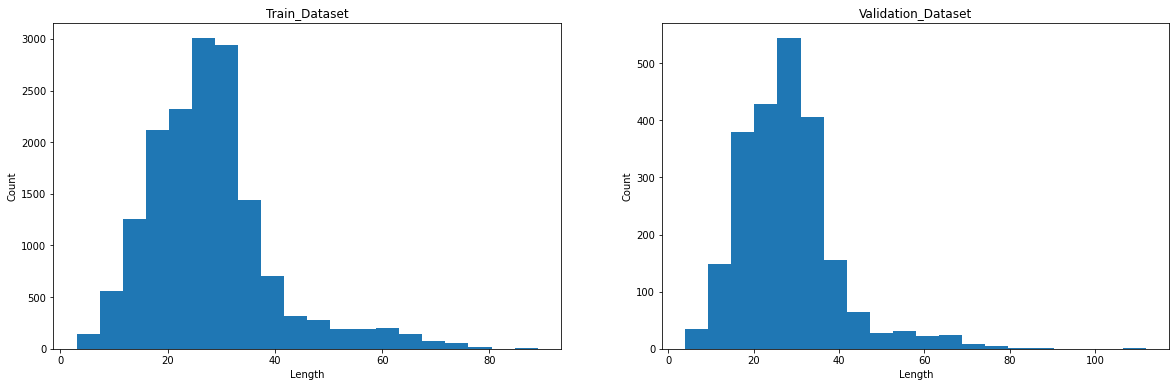

In [ ]:
train_toks = tokenizer(text=list(train_dataset['tweet'].values))
val_toks = tokenizer(text=list(validation_dataset['tweet'].values))

train_lengths = [len(l) for l in train_toks['input_ids']]
val_lengths = [len(l) for l in val_toks['input_ids']]

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].hist(train_lengths, bins=20)
ax[0].set_title("Train_Dataset")
ax[0].set_xlabel("Length")
ax[0].set_ylabel("Count")

ax[1].hist(val_lengths, bins=20)
ax[1].set_title("Validation_Dataset")
ax[1].set_xlabel("Length")
ax[1].set_ylabel("Count")

print("Max train length = ", max(train_lengths))
print("Max validation length = ", max(val_lengths))

As you can see, both datasets have an average of about 20-40 tokens per tweet. However, in the tokenizer i will set the max lengths in the corresponding parameter as they are not so big in order not to lose any information. 

**Create custom dataset class**

Now let's create the custom dataset class which also handle the tokenization part. This way, the tokenization happens during training and validation and we don't consume ram to save all the tokenizations in prior.

In [ ]:
class BertTweetsDataset(Dataset):
  def __init__(self, tweets, labels, tokenizer: BertTokenizer, max_len: int):
    self.tweets = tweets
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len=max_len

  def __len__(self):
    return len(self.tweets)

  def __getitem__(self, idx):
    enc = self.tokenizer(self.tweets[idx], max_length=self.max_len, padding='max_length', truncation=True, return_token_type_ids=False, return_tensors='pt').to(device)
    return {'input_ids': enc['input_ids'], 'attention_mask': enc['attention_mask'], 'labels': torch.tensor(self.labels[idx], dtype=torch.long, device=device)}

In [ ]:
train_bert_dataset = BertTweetsDataset(list(train_dataset['tweet'].values), train_dataset['label'].values, tokenizer=tokenizer, max_len=89)

In [ ]:
validation_bert_dataset = BertTweetsDataset(list(validation_dataset['tweet'].values), validation_dataset['label'].values, tokenizer=tokenizer, max_len=112)

In [ ]:
test_bert_dataset = BertTweetsDataset(list(test_dataset['tweet'].values), test_dataset['label'].values, tokenizer=tokenizer, max_len=120)

But on the test set, i gave 120 for max length in order to give more flexibility because i don't really know in advance it's true max length.

**Create Dataloaders**

In [ ]:
BATCH_SIZE=128

In [ ]:
train_dataloader = DataLoader(train_bert_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
validation_dataloader = DataLoader(validation_bert_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
test_dataloader = DataLoader(test_bert_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Model Definition

**General Model**

Now let's define the model class. What i did is add a fully connected linear layer in the [CLS] token output with 3 output neurons (one for each of the 3 classes), and a dropout layer between cls token and the fully connected layer.

In [ ]:
class BertClassifier(nn.Module):
  def __init__(self, dropout=0):
    super(BertClassifier, self).__init__()
    self.bert_model = BertModel.from_pretrained(BERT_MODEL_NAME).to(device)
    self.dropout = nn.Dropout(dropout)
    self.fc = nn.Linear(768, 3, device=device)

  def forward(self, input_ids, att_mask):
    out = self.bert_model(input_ids, att_mask)
    out = self.dropout(out[1])
    out = self.fc(out)
    return out

  # Makes predictions in the dataloader's dataset and returns predicted labels, true labels and scores
  def predict(self, dataloader: DataLoader):
    with torch.no_grad():
      self.eval()
      y_true = torch.tensor([], dtype=torch.int, device='cpu')
      y_pred = torch.tensor([], device='cpu')
      scores = torch.tensor([], device='cpu')
      for batch in dataloader:
        y_true = torch.cat((y_true, batch['labels'].squeeze().cpu()))
        score = self(batch['input_ids'].squeeze(), batch['attention_mask'].squeeze())
        scores = torch.cat((scores, score.cpu()))
        _, y_pred_labels = torch.max(score, 1)
        y_pred = torch.cat((y_pred, y_pred_labels.cpu()))
      return y_pred, y_true, scores

And also define an accuracy calculation function:

In [ ]:
def accuracy(true_labels: torch.tensor, predicted_labels: torch.tensor):
  total = true_labels.size(0)
  correct = (true_labels == predicted_labels).sum().item()
  return 100 * correct / total

**Training Function**

Now, let's define the training function.

In [ ]:
def train(model: BertClassifier, dataloader: DataLoader, validation_dataloader: DataLoader, learning_rate: float, epochs: int):
  # Define the loss function
  loss_function = nn.CrossEntropyLoss()

  # Define the optimizer
  opt = torch.optim.AdamW(model.parameters(), lr=learning_rate)

  # Initialize train and validation losses lists
  train_losses = []
  validation_losses = []

  # Train for given # of epochs
  for epoch in range(epochs):
    model.train()
    t_losses = []
    for batch in dataloader:
      # Delete previously stored gradients
      opt.zero_grad()
      # Calculate prediction probabilities
      y_pred = model(batch['input_ids'].squeeze(), batch['attention_mask'].squeeze())
      # Calculate loss
      loss = loss_function(y_pred, batch['labels'].squeeze())
      # Perform backpropagation starting from the loss calculated in this epoch
      loss.backward()
      # # Clip params
      # nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      # Update model's weights based on the gradients calculated during backprop
      opt.step()
      t_losses.append(loss.item())
    
    # Calculate train loss in current epoch
    train_loss = np.mean(t_losses) 
    train_losses.append(train_loss)
    
    # Calculate validation loss, f1 score and accuracy for the current epoch
    y_pred, y_true, scores = model.predict(validation_dataloader)
    val_loss = loss_function(scores, y_true).item()
    validation_losses.append(val_loss)
    acc = accuracy(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Print current epoch status
    print(f"Epoch {epoch:3}: Loss = {train_loss:.5f} Val_loss = {val_loss:.5f} Val_accuracy = {acc:.5f} F1_Score = {f1:.5f}")
  return train_losses, validation_losses

And also some functions for scores computations and also evaluation processes.

In [ ]:
def plot_loss_vs_epochs(train_losses, val_losses):
  assert(len(train_losses) == len(val_losses))
  plt.grid()
  plt.plot(list(range(len(train_losses))), train_losses, "o-", label="Train")
  plt.plot(list(range(len(train_losses))), val_losses, "o-", label="Validation")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

In [ ]:
def evaluate_model(y_true: torch.tensor, y_pred: torch.tensor):
  print(classification_report(y_true, y_pred))
  print("Precision:", precision_score(y_true, y_pred, average='weighted'))
  print("Recall:", recall_score(y_true, y_pred, average='weighted'))
  print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))
  cm = confusion_matrix(y_true, y_pred)
  cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
  cm_disp.plot()
  plt.show()

In [ ]:
def plot_roc_curve(y_true: torch.tensor, scores: torch.tensor):
  y_true = label_binarize(y_true, classes=[0, 1, 2])

  fpr, tpr, _ = roc_curve(y_true.ravel(), scores.ravel())
  roc_auc= auc(fpr, tpr)

  plt.figure()
  plt.plot(
      fpr,
      tpr,
      label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc),
      color="darkorange",
  )
  plt.plot([0, 1], [0, 1], color="navy",lw=2, linestyle="--")
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.legend(loc="lower right")
  plt.show()

**Training**

And now, time for training...

Parameters used:


*   Batch Size = 128
*   Learning Rate = 2e-5
*   Dropout rate = 30%
*   Epochs = 4





In [ ]:
reset_seed()

In [ ]:
model = BertClassifier(dropout=0.2)
model

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertClassifier(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

In [ ]:
train_losses, validation_losses = train(model, train_dataloader, validation_dataloader, learning_rate=2e-5, epochs=4)

Epoch   0: Loss = 0.74460 Val_loss = 0.60435 Val_accuracy = 75.28484 F1_Score = 0.74977
Epoch   1: Loss = 0.55383 Val_loss = 0.57086 Val_accuracy = 76.20508 F1_Score = 0.75830
Epoch   2: Loss = 0.42861 Val_loss = 0.61614 Val_accuracy = 76.07362 F1_Score = 0.75802
Epoch   3: Loss = 0.33062 Val_loss = 0.62739 Val_accuracy = 77.82647 F1_Score = 0.77739


In [ ]:
y_pred, y_true, scores = model.predict(test_dataloader)

              precision    recall  f1-score   support

           0       0.87      0.78      0.83      1065
           1       0.70      0.55      0.62       296
           2       0.71      0.84      0.77       921

    accuracy                           0.78      2282
   macro avg       0.76      0.73      0.74      2282
weighted avg       0.79      0.78      0.78      2282

Precision: 0.7856472073267561
Recall: 0.7782646801051709
F1 Score: 0.7773899364221059


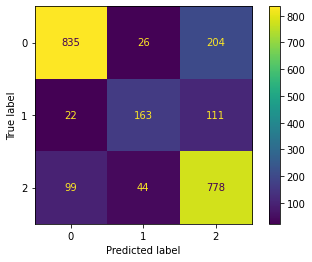

In [ ]:
evaluate_model(y_true, y_pred)

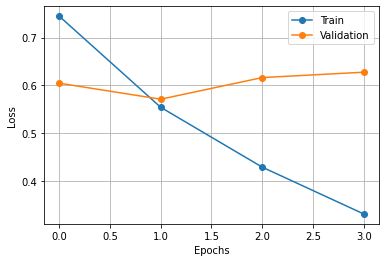

In [ ]:
plot_loss_vs_epochs(train_losses, validation_losses)

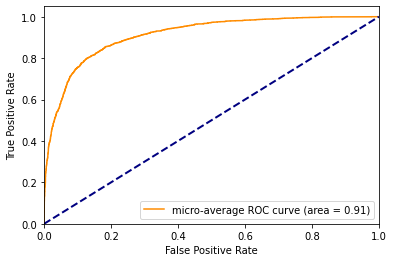

In [ ]:
plot_roc_curve(y_true, scores)

As you can see we get a remarkable improvement in the accuracy compared to the previous Bidirectional LSTM model with 73.9% accuracy!!!

77.8 - 73.9 = **3.9% better accuracy!!!**

This was definitely expected because:

*   BERT is a much more advanced language model 
*   It was pre-trained on a huge Wikipedia corpus
*   It handles contextual information and attention in much more clever way.



